In [1]:
%load_ext autoreload
%autoreload 2

import os
import csv
import numpy as np
import shapely
import pytorch_lightning as pl
import matplotlib.pyplot as plt


from torch.utils.data import DataLoader, RandomSampler, ConcatDataset
from pytorch_lightning.utilities import CombinedLoader
from pathlib import Path
from datetime import datetime

import dl_toolbox.callbacks as callbacks
import dl_toolbox.modules as modules 
import dl_toolbox.networks as networks
import dl_toolbox.datasets as datasets
import dl_toolbox.torch_collate as collate
import dl_toolbox.utils as utils

import rasterio.windows as windows

test = True
if os.uname().nodename == 'WDTIS890Z': 
    data_root = Path('/mnt/d/pfournie/Documents/data')
    home = Path('/home/pfournie')
    save_root = data_root / 'outputs'
elif os.uname().nodename == 'qdtis056z': 
    data_root = Path('/data')
    home = Path('/d/pfournie')
    save_root = data_root / 'outputs'
elif os.uname().nodename.endswith('sis.cnes.fr'):
    home = Path('/home/eh/fournip')
    save_root = Path('/work/OT/ai4usr/fournip') / 'outputs'
    if test:
        data_root = Path('/work/OT/ai4geo/DATA/DATASETS')
    else:
        #!bash '/home/eh/fournip/dl_toolbox/copy_data_to_node.sh'
        data_root = Path(os.environ['TMPDIR'])

/work/OT/ai4usr/fournip/latest/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
# datasets params
dataset_name = 'DIGITANIE'
data_path = data_root / dataset_name
nomenclature = datasets.DigitanieNomenclatures['building'].value
num_classes=len(nomenclature)
crop_size=512
crop_step=256
bands = [1,2,3]

# split params
split = home / f'dl_toolbox/dl_toolbox/datamodules/digitanie_all.csv'

pred_idx = [i+j for i in [0, 66, 88, 99, 110, 154] for j in range(9,11)]
pred_idx = [75]
pred_aug = 'no'

# dataloaders params
batch_size = 16
epoch_steps = 500
num_samples = epoch_steps * batch_size
num_workers=6

# network params
in_channels=len(bands)
out_channels=num_classes
pretrained = False
encoder='efficientnet-b1'

# module params
mixup=0. # incompatible with ignore_zero=True
class_weights = [1.] * num_classes
initial_lr=0.001
ttas=[]
alpha_ramp=utils.SigmoidRamp(2,4,0.,0.)
pseudo_threshold=0.9
consist_aug='color-5'
ema_ramp=utils.SigmoidRamp(2,4,0.9,0.99)

# trainer params
num_epochs = 30
#max_steps=num_epochs * epoch_steps
accelerator='gpu'
devices=1
multiple_trainloader_mode='min_size'
limit_train_batches=1.
limit_val_batches=1.
save_dir = save_root / dataset_name

log_dir = Path('/work/OT/ai4usr/fournip/outputs/DIGITANIE/fra->Nantes/26Apr23-09h40m53')
ckpt_path = log_dir/'checkpoints'/'epoch=29-step=30000.ckpt'

In [9]:
network = networks.SmpUnet(
    encoder=encoder,
    in_channels=in_channels,
    out_channels=out_channels,
    pretrained=pretrained
)

### Building lightning module
module = modules.Supervised(
    mixup=mixup, # incompatible with ignore_zero=True
    network=network,
    num_classes=num_classes,
    class_weights=class_weights,
    initial_lr=initial_lr,
    ttas=ttas,
    #alpha_ramp=alpha_ramp,
    #pseudo_threshold=pseudo_threshold,
    #consist_aug=consist_aug,
    #ema_ramp=ema_ramp
)

/work/OT/ai4usr/fournip/latest/lib/python3.8/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python3 /work/OT/ai4usr/fournip/latest/lib/python3.8/site-p ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Restoring states from the checkpoint path at /work/OT/ai4usr/fournip/outputs/DIGITANIE/fra->Nantes/26Apr23-09h40m53/checkpoints/epoch=29-step=30000.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /work/OT/ai4usr/fournip/outputs/DIGITANIE/fra->Nantes/26Apr23-09h40m53/checkpoints/epoch=29-step=30000.ckpt


Predicting DataLoader 0: 100%|██████████| 4/4 [00:02<00:00,  1.74it/s]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


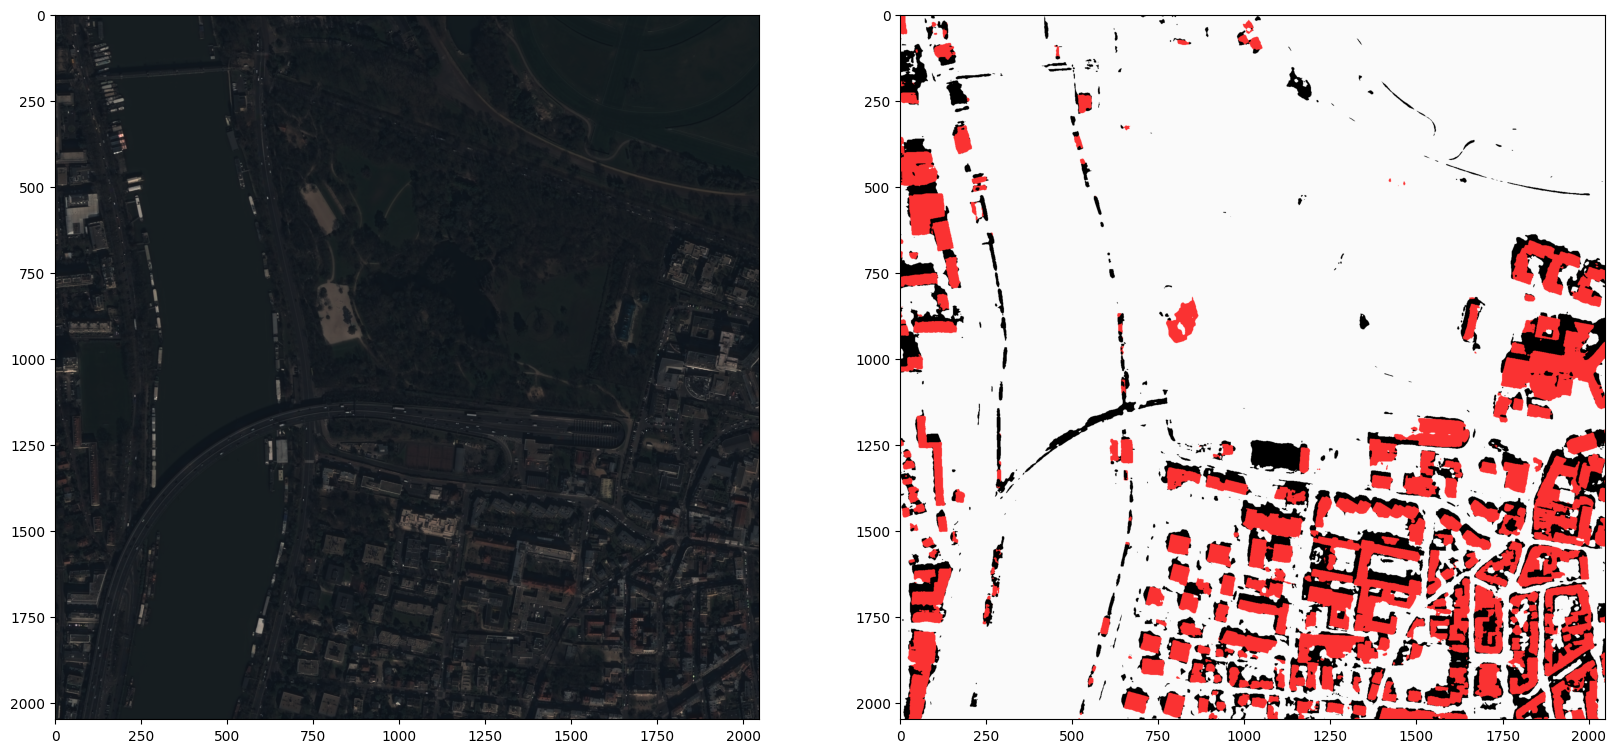

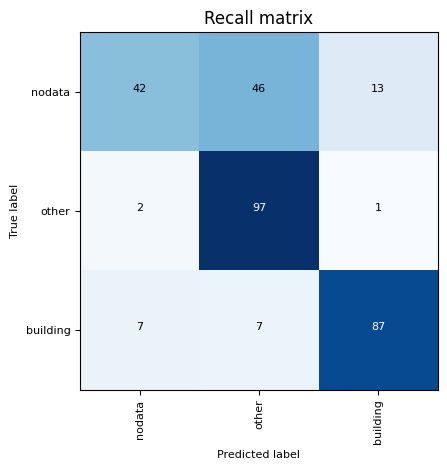

In [10]:
%matplotlib inline

pred_dir = log_dir/dataset_name

pred_data_src = [
    src for src in datasets.datasets_from_csv(
        data_path,
        split,
        pred_idx
    )
]

pred_sets = [
    datasets.PretiledRaster(
        data_src=src,
        crop_size=crop_size,
        crop_step=crop_size//2,
        aug=pred_aug,
        bands=bands,
        nomenclature=nomenclature
    ) for src in pred_data_src
]

for pred_set in pred_sets:
    
    pred_dataloader = DataLoader(
        dataset=pred_set,
        shuffle=False,
        collate_fn=collate.CustomCollate(),
        batch_size=batch_size,
        num_workers=num_workers
    )

    pred_writer = callbacks.MergedTiffPredsWriter(
        out_path=pred_dir,
        write_mode='pred',
        data_src=pred_set.data_src,
        crop_size=pred_set.crop_size,
        merge_mode='linear'
    )

    pred_trainer = pl.Trainer(
        accelerator=accelerator,
        devices=devices,
        logger=False,
        callbacks=[
            pred_writer,
            #callbacks.MyProgressBar(),
        ]
    )
    
    pred_trainer.predict(
        model=module,
        dataloaders=pred_dataloader,
        return_predictions=False,
        ckpt_path=ckpt_path
    )
    
    confs, preds = module.probas2confpreds(pred_writer.merged.unsqueeze(dim=0))
    image, label = pred_set.read_crop(crop=pred_set.data_src.zone)

    conf_mat = callbacks.compute_conf_mat(
        label.flatten(),
        preds.flatten(),
        num_classes,
        ignore_idx=None
    )
    
    fig = plt.figure(figsize=(20,20))
    ax1 = fig.add_subplot(121)
    ax1.imshow(image.numpy().transpose(1,2,0)[...,:3])
    ax2 = fig.add_subplot(122)
    ax2.imshow(utils.NomencToRgb(nomenclature)(preds.squeeze()))

    fig = utils.plot_confusion_matrix(
        conf_mat,
        [label.name for label in nomenclature],
        'recall'
    )